# Stratified spaces

$\textbf{Lead Author: Anna Calissano}$

Dear lerner, 
the aim of the current notebook is to introduce stratified spaces and its implementation within geomstats. 

## Spider

The $k$-Spider consists of $k$ copies of the positive real line $\mathbb{R}_{\geq 0}$ glued together at the origin. Within geomstats, we defined the following:
1. Spider Point: a point object defining the ray and the value
2. Spider: the space defined by the number of rays
3. Spider Geometry: by chosing a metric on the rays, we can define a metric on the whole space

<img src="figures/tripod.png" width="200px"/>

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

import geomstats.backend as gs

gs.random.seed(2020)

from geomstats.geometry.stratified.spider import Spider, SpiderPoint, SpiderMetric
from geomstats.geometry.euclidean import EuclideanMetric

INFO: Using numpy backend


We can define a spider with $k=3$ rays (strata) and sample two points from it.

In [2]:
sp= Spider(n_rays=3)
sp.n_rays

3

In [3]:
sp_points=sp.random_point(n_samples=2)
sp_points


[r0: 0.0, r0: 0.0]

The points are represented into the SpiderPoint format, where the first input is the stratum and the second input is the value along the stratum.

In [4]:
print(sp_points[0].stratum)
print(sp_points[0].stratum_coord)

0
0.0


Given a metric $d_{rays}$ on the strata (the rays), we can extend it to the whole space by $$d_{Spider}(s_1,s_2)=d_{rays}(s_1,0) + d_{rays}(0,s_2)$$

In [5]:
sp_metric=SpiderMetric(ray_metric=EuclideanMetric(dim=1), space=sp)

Given two points on the Spider, we can compute the distance between the two points as well as the geodesic between the two.

In [6]:
sp_metric.dist(sp_points[0], sp_points[1])

0.0

In [7]:
sp_geo=sp_metric.geodesic(sp_points[0], sp_points[1])
print(sp_geo(0), sp_geo(0.5), sp_geo(1))

[r0: 0.0] [r0: 0.0] [r0: 0.0]


## Graph Space

Graph Space is a space defined to describe set of graphs with a finite number of nodes which can be both node labelled or node unlabelled. 

Inspired by: A. Calissano, A. Feragen, S. Vantini, Populations of unlabeled networks: Graph space geometry and geodesic principal components, MOX Report (2020)


We consider graphs as triples  $G=(V,E,a)$, where the node set $V$ has at most $n$ elements, and the edge set $E \subset V^2$ has maximal size 
$n^2$. The nodes and edges are attributed with elements of an attribute space $A$, which is considered to be Euclidean, via an attribute 
map $a \colon E \rightarrow A$. Here, the map $a$ allows us to describe attributes on both edges and nodes, as we use self loop edges (diagonal 
elements in the graphs adjacency matrix) to assign attributes to nodes. 
A graph with scalar attributes is completely specified by a weighted adjacency matrix of dimension $n\times n$, residing in a space 
$X=\mathbb{R}^{n^2}$ of flattened adjacency matrices. If the attributes are vectors of dimension $d$, the graph is represented by a tensor of 
dimension $n\times n\times d$, residing in a space $X=\mathbb{R}^{n\times n\times d}$.

In [8]:
from geomstats.geometry.stratified.graph_space import (
    Graph,
    GraphSpace,
    GraphSpaceMetric,
)
import networkx as nx
import geomstats.backend as gs
import matplotlib.pyplot as plt

### Graph
Consider a graph with $n=3$ nodes and $A=\mathbb{R}$ scalar attributes on nodes and edges. The class Graph describe a single graph via its adjacency matrix.

In [9]:
adj= gs.array([[10,3,1],[3,2,4],[1,4,5]])
gr=Graph(adj=adj)
gr.adj

array([[10,  3,  1],
       [ 3,  2,  4],
       [ 1,  4,  5]])

To simplify the visualization and the access to different methods, the Graph object can be turned into a networkx graph.

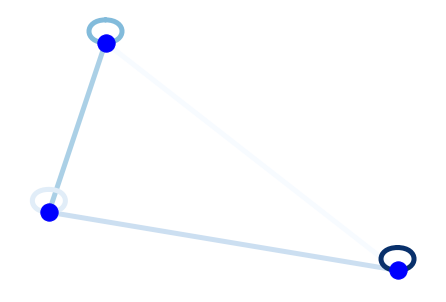

In [10]:
gr_nx = gr.to_networkx()
edges,weights = zip(*nx.get_edge_attributes(gr_nx,'weight').items())
pos = nx.spring_layout(gr_nx)
nx.draw(gr_nx, pos, node_color='b', edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues)

### Set of Graphs: GraphSpace
Graphs can have different numbers of nodes and different node labels or order. We assume the existence across the populations of at most $n$ distinct nodes and we add fictionally null nodes to smaller networks, so that all graphs can be described by a fixed-size adjacency matrix. Graph Space is initalized by the maximal number of nodes in the set. 

In [11]:
g_s = GraphSpace(n_nodes= 4)
g_s.n_nodes

4

Within GraphSpace, we can sample points from random adjacency matrices, we can check if the points belongs and we can return a set of adjacency matrices.

In [12]:
gr_sampled = g_s.random_point(2)

In [13]:
g_s.belongs(gr)

True

### Labelled or Unlabelled?
Graphs can be considered labelled or unlablled, meaning that the observation in the set can share the same nodes (labelled) or not (unlabelled). We can describe both cases into Graph Space by using a little trick.

To deal with unlabelled nodes, matching two graphs corresponds to finding optimal permutations of their nodes. By allowing node permutation, a concept of equivalence class is introduces (i.e., every network is associated to the set of 
networks obtained by permuting the original one). In geometrical terms, this can be described as a quotient space obtained by applying a permutation 
action to the set of adjacency matrix. 

In details, the group of node permutations $T$ can be represented via permutation matrices, acting on $X$ 
through matrix multiplication. The binary operation: 

$$\cdot \colon T \times X \rightarrow X, (T,x)\mapsto Tx $$

thus defines an action of the group $T$ on $X$. The obtained quotient space $X/T$ is called graph space, and 
each element of $X/T$ is an unlabelled graph $G$, represented as an equivalence class $[x]=Tx$ which contains all the flattened adjacency matrices 
in $X$ which can be obtained from $x$ by permuting nodes. The map $\pi \colon X \to X/T$ given by $\pi(x) = [x]$ can be thought of as a 
projection of the Euclidean total space $X$ onto the graph space $X/T$, and the total space $X$ plays a similar role relative to graph space, 
as the tangent space does for manifolds, by providing a Euclidean space in which approximate computations can be carried out and projected back onto 
the space of interest -- in our case the graph space $X/T$.


To deal with labelled nodes, we restrict the set of permutation matrices to the identity: $T=\{I\}$

### Graph Space Metric

To define a metric on graph space, we need to chose a metric on the total space.
Any metric $d_X$ on $X$ defines a quotient pseudo-metric

$$d_{X/T}([x_1],[x_2])=\min_{t\in T}d_X(x_1,t^Tx_2t)$$

on $X/T$. Since the permutation group $T$ is finite, $d_{X/T}$ is a metric, and the graph space $X/T$ is a geodesic space. In the implementation, we suppose that the default metric in the total space is the Frobenius norm between adjacency matrix.

In [14]:
gs_m= GraphSpaceMetric(space=g_s)
gs_m.total_space_metric

### Graph Matching
The metric on Graph Space relies on the optimization along the quotient fibers. In this context the optimization problem is known as graph matching (or graph alignment) and corresponds in finding a match between the two sets of nodes which minimize the distance between the corresponding adjacency matrices. The distance function needs a matcher input, which solve the minimization problem by returning an optimal permutation of the second input graph. Two matchers are called:

1. 'ID' the identity matching returning the same node order which corresponds to work with labelled graphs;
2. 'FAQ' the Fast Quadratic Assignment Matching implemented in scipy.optimize.quadratic assignment which is the state of the art in the matching literature based on the Frobenius norm.

In [15]:
gs_m.dist(graph_a=gr_sampled[0], graph_b= gr_sampled[1])

1.4460818164862586

In [16]:
gs_m.set_matcher("FAQ")

gs_m.dist(graph_a=gr_sampled[0], graph_b=gr_sampled[1])

1.3431542528099538

In [17]:
gs_m.matching(gr_sampled, gr_sampled)  # with FAQ matcher

array([[0, 1, 2, 3],
       [0, 1, 2, 3]])